In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
from alive_progress import alive_bar
import time
import os

# Load the data
train_data = pd.read_parquet("data/train_data.parquet")
# test_data = pd.read_parquet("data/test_data.parquet")
test_data = pd.read_csv("final_day/matching/output_full.csv")

# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()

In [99]:
data_path = "data"
output_path = "output/"
temp_path = "tmp/"

sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
submission_cols = sample_submission.columns.tolist()

In [100]:
pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), test_data.columns.tolist()
    )
)
len(pred_cols)

52

## Setting 20 columns to nan randomly in each row

In [79]:
# if os.path.exists(f"{temp_path}/sample_val.csv") and os.path.exists(f"{temp_path}/val_Y.csv"):
#   # If the sample files already exist, load them
#   sample_val = pd.read_csv(f"{temp_path}/sample_val.csv")
#   val_Y = pd.read_csv(f"{temp_path}/val_Y.csv")
#   print("Loaded existing sample_val and val_Y.")
# else:
#   # Create a copy of val_data to avoid modifying the original
#   sample_val = val_data.copy()

#   # Get the call and put columns separately
#   call_cols = [col for col in pred_cols if col.startswith('call')]
#   put_cols = [col for col in pred_cols if col.startswith('put')]

#   # For each row, randomly select 16 call columns and 16 put columns to set to NaN
#   for idx in sample_val.index:
#     # Randomly select 16 call columns for this row
#     nan_call_cols = np.random.choice(call_cols, size=10, replace=False)
    
#     # Randomly select 16 put columns for this row
#     nan_put_cols = np.random.choice(put_cols, size=10, replace=False)
    
#     # Set these columns to NaN for this row
#     sample_val.loc[idx, nan_call_cols] = np.nan
#     sample_val.loc[idx, nan_put_cols] = np.nan

#   # Create val_Y from the original validation data, containing only the target columns
#   val_Y = val_data[pred_cols]
#   sample_val.to_csv(f"{temp_path}/sample_val.csv", index=False)
#   val_Y.to_csv(f"{temp_path}/val_Y.csv", index=False)

In [80]:
sample_val = pd.read_parquet("final_day/sample_val.parquet")
val_Y = pd.read_parquet("final_day/val_Y.parquet")

In [81]:
sample_val

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
158881,1746590742000000000,24433.0,2025-05-08,0.435793,0.409610,0.383775,0.356050,NaN,NaN,NaN,...,-0.022656,0.006262,2.553592e+06,-0.001931,2.372125,0.068108,-1.522534e+06,-3.048516e+06,1.254699e+06,-0.000000e+00
117518,1746176782000000000,24285.5,2025-05-08,NaN,NaN,0.187751,0.178467,0.170073,0.161772,0.154975,...,0.003836,-0.004734,6.693594e+05,0.010055,1.315715,0.030237,5.235704e+04,-8.124241e+06,1.313372e+06,-1.000000e-06
155403,1746520665000000000,24387.5,2025-05-08,NaN,0.270770,NaN,NaN,NaN,0.173109,NaN,...,0.001037,0.003309,2.847738e+06,0.008796,0.648142,0.041674,3.459928e+05,-2.764208e+07,2.203250e+06,0.000000e+00
159498,1746591359000000000,24384.6,2025-05-08,0.426385,0.396069,NaN,0.341066,NaN,NaN,0.242813,...,0.035097,-0.030470,-3.629051e+06,0.146150,-8.941554,1.278703,6.211531e+06,7.623811e+06,-5.587995e+05,3.208558e+06
106693,1746165957000000000,24329.3,2025-05-08,NaN,NaN,0.196625,NaN,NaN,NaN,NaN,...,0.001900,0.002318,-1.051215e+06,0.026776,0.242156,0.025405,2.716713e+06,-3.698245e+06,-0.000000e+00,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159879,1746591740000000000,24335.0,2025-05-08,NaN,0.377406,0.349971,NaN,NaN,0.256396,NaN,...,0.008603,-0.004291,-1.986960e+06,0.012081,-1.567061,0.025376,-1.849046e+05,9.476678e+05,-8.574375e+05,-0.000000e+00
152103,1746517365000000000,24379.3,2025-05-08,0.281599,0.263384,0.241601,NaN,NaN,NaN,0.149054,...,-0.009330,0.001730,3.085312e+05,-0.010100,0.017339,0.041731,-5.464379e+06,9.938785e+06,0.000000e+00,0.000000e+00
145579,1746510841000000000,24383.8,2025-05-08,0.277396,0.256449,NaN,0.214142,0.191823,0.168970,0.146202,...,-0.006017,-0.014316,-5.171651e+05,0.009618,-0.905712,-0.035879,-5.117804e+05,-3.953448e+07,1.914297e+05,-0.000000e+00
171749,1746603610000000000,24348.2,2025-05-08,0.386717,0.355572,0.323200,0.296829,NaN,NaN,0.190997,...,0.001378,0.003366,1.357577e+06,0.016415,0.766966,-0.016124,-9.293144e+05,6.414991e+06,3.323359e+04,0.000000e+00


In [82]:
sample_val.shape

(23753, 97)

In [101]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from tqdm import tqdm
from multiprocess import Pool, cpu_count
from scipy.interpolate import CubicSpline


def fit_cubic_spline_row(args):
    """
    Fit cubic spline on given row and return values for each strike price.

    Parameters: args: tuple - (row, cols, normalize)
    row: pandas Series - row containing IV data
    cols: list - column names for IV values (e.g., call_cols or put_cols)
    normalize: bool - whether to normalize strike prices for better accuracy

    Returns:
    numpy array - fitted IV values for all strike prices
    """
    #imporint again for parallel processing
    import numpy as np
    import pandas as pd
    from scipy.optimize import minimize
    from tqdm import tqdm
    from multiprocess import Pool, cpu_count
    from scipy.interpolate import CubicSpline

    
    row, cols, normalize = args
    ivs = row[cols].values.astype(np.float64)
    strikes = np.array([float(c.split("_")[-1]) for c in cols])

    # Filter out NaN values
    valid = ~np.isnan(ivs)
    if valid.sum() < 3:  # Need at least 3 points for cubic spline
        return ivs

    iv_valid = ivs[valid]
    strikes_valid = strikes[valid]

    # Normalize strikes if requested
    if normalize:
        F = row["underlying"]
        # F = 1;
        strikes_norm = strikes_valid / F
        strikes_all_norm = strikes / F

        try:
            # Fit cubic spline on normalized strikes
            cs = CubicSpline(strikes_norm, iv_valid, bc_type="natural")
            iv_fitted = cs(strikes_all_norm)
        except:
            # Fallback to non-normalized if normalization fails
            try:
                cs = CubicSpline(strikes_valid, iv_valid, bc_type="natural")
                iv_fitted = cs(strikes)
            except:
                return ivs
    else:
        try:
            cs = CubicSpline(strikes_valid, iv_valid, bc_type="natural")
            iv_fitted = cs(strikes)
        except:
            return ivs

    # Ensure fitted values are positive (IV cannot be negative)
    iv_fitted = np.maximum(iv_fitted, 0.0001)

    return iv_fitted



In [102]:
call_cols = [col for col in pred_cols if col.startswith('call')]
put_cols = [col for col in pred_cols if col.startswith('put')]

In [103]:
def parallel_fit_spline(df, cols, normalize=True, processes=8, batch_size=500):
    if processes is None:
        processes = max(cpu_count() - 1, 1)
    print("Starting parallel Cubic Spline fitting with", processes, "processes")
    df_filled = df.copy()
    n = len(df)
    for start in tqdm(range(0, n, batch_size), desc="Fitting Cubic Spline"):
        end = min(start + batch_size, n)
        batch = df.iloc[start:end]
        args = [(row, cols, normalize) for _, row in batch.iterrows()]

        with Pool(processes) as pool:
            results = pool.map(fit_cubic_spline_row, args)

        for i, new_ivs in enumerate(results):
            df_filled.iloc[start + i, df.columns.get_indexer(cols)] = new_ivs

    return df_filled

# Prediction based on only testing data

In [ ]:
# # Define columns with IVs
# cols_call = [col for col in sample_val.columns if col.startswith('call')]
# cols_put = [col for col in sample_val.columns if col.startswith('put')]
# df = sample_val.copy()
# df_filled = parallel_fit_spline(
#    sample_val , cols_call, normalize=True, processes=8, batch_size=200
# )
# sample_val = df_filled.copy();
# df_filled = parallel_fit_spline(
#    sample_val , cols_put, normalize=True, processes=8, batch_size=200
# )
# sample_val = df_filled.copy()
# print("Cubic Spline fitting completed.")
# print("rmse:", rmse(val_Y[pred_cols], sample_val[pred_cols]))

Starting parallel Cubic Spline fitting with 8 processes


Fitting Cubic Spline:   0%|          | 0/119 [00:00<?, ?it/s]

Fitting Cubic Spline: 100%|██████████| 119/119 [02:47<00:00,  1.40s/it]


Starting parallel Cubic Spline fitting with 8 processes


Fitting Cubic Spline: 100%|██████████| 119/119 [03:24<00:00,  1.72s/it]

Cubic Spline fitting completed.


ValueError: Input contains NaN.

In [ ]:
# sample_val.isna().sum().sum()
# sample_val[pred_cols] =sample_val[pred_cols].fillna(0.2)



In [ ]:
# print("rmse:", rmse(val_Y[pred_cols], sample_val[pred_cols]))

rmse: 0.017256200584843874


ValueError: Input contains NaN.

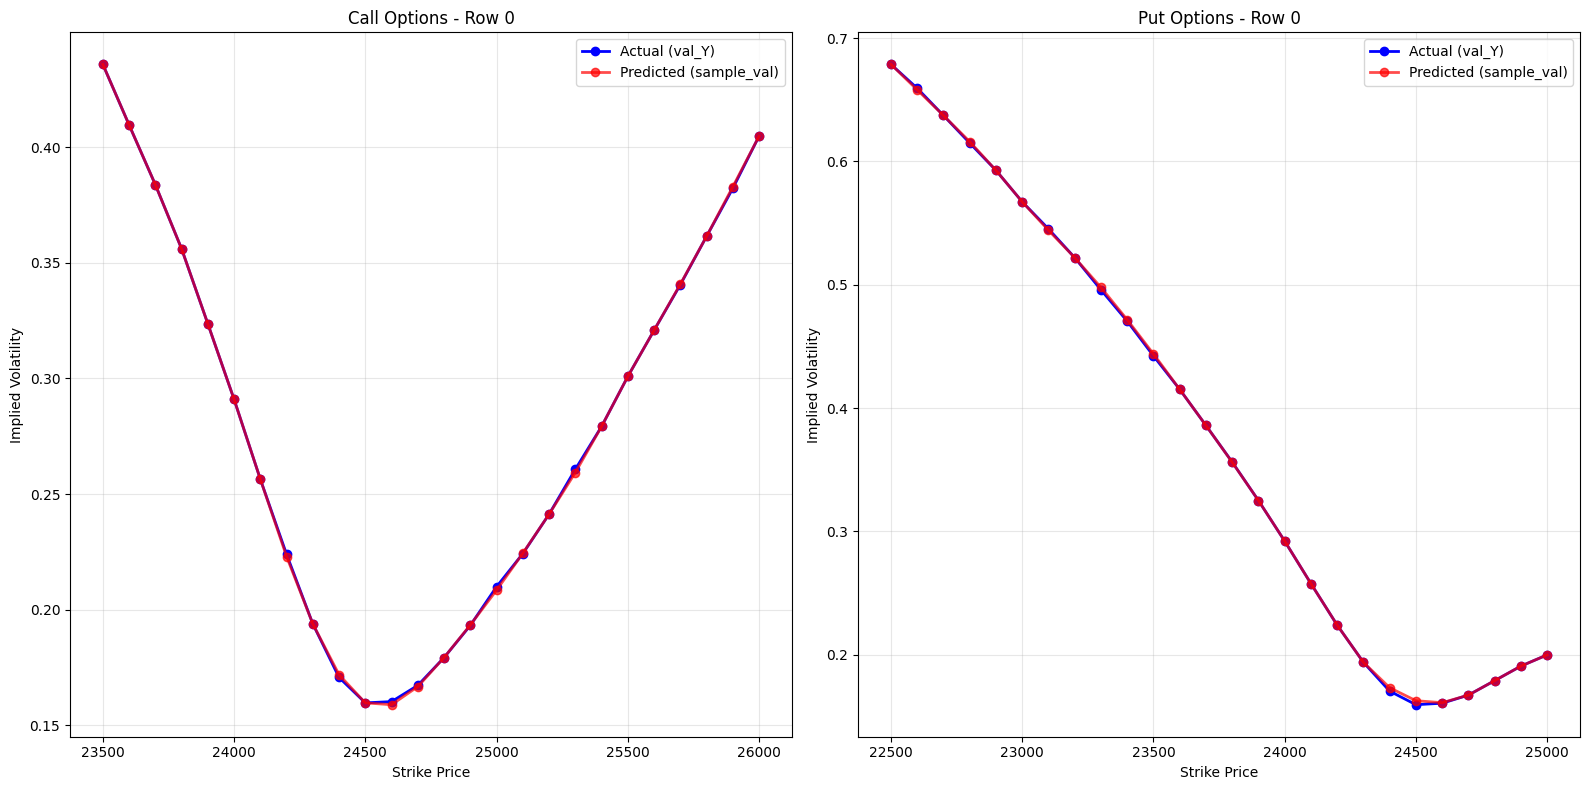

In [ ]:
def plot_validation_comparison(row_idx):
  """
  Plot comparison between predicted values (sample_val) and actual values (val_Y) for a specific row
  
  Parameters:
  row_idx (int): The index of the row to plot
  """
  plt.figure(figsize=(16, 8))
  
  # Get call and put columns
  call_cols = [col for col in pred_cols if col.startswith('call')]
  put_cols = [col for col in pred_cols if col.startswith('put')]
  
  # Extract strike prices
  call_strikes = np.array([float(col.split('_')[-1]) for col in call_cols])
  put_strikes = np.array([float(col.split('_')[-1]) for col in put_cols])
  
  # Plot call options
  plt.subplot(1, 2, 1)
  plt.plot(call_strikes, val_Y.iloc[row_idx][call_cols], 'bo-', label='Actual (val_Y)', linewidth=2, markersize=6)
  plt.plot(call_strikes, sample_val.iloc[row_idx][call_cols], 'ro-', label='Predicted (sample_val)', linewidth=2, markersize=6, alpha=0.7)
  plt.title(f'Call Options - Row {row_idx}')
  plt.xlabel('Strike Price')
  plt.ylabel('Implied Volatility')
  plt.legend()
  plt.grid(True, alpha=0.3)
  
  # Plot put options
  plt.subplot(1, 2, 2)
  plt.plot(put_strikes, val_Y.iloc[row_idx][put_cols], 'bo-', label='Actual (val_Y)', linewidth=2, markersize=6)
  plt.plot(put_strikes, sample_val.iloc[row_idx][put_cols], 'ro-', label='Predicted (sample_val)', linewidth=2, markersize=6, alpha=0.7)
  plt.title(f'Put Options - Row {row_idx}')
  plt.xlabel('Strike Price')
  plt.ylabel('Implied Volatility')
  plt.legend()
  plt.grid(True, alpha=0.3)
  
  plt.tight_layout()
  plt.show()

# Plot comparison for a specific row
plot_validation_comparison(0)

In [ ]:
sample_val[call_cols].isna().sum().sum()

0

In [104]:
final_test_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), test_data.columns.tolist()
    )
)
len(final_test_cols)

52

In [105]:
test_data[final_test_cols].isna().sum().sum()

1816

In [106]:
cols_call = [col for col in test_data.columns if col.startswith("call")]
cols_put = [col for col in test_data.columns if col.startswith("put")]


# Apply SVI fitting across full dataset in parallel with progress bar
df_filled = parallel_fit_spline(test_data, cols_call, normalize=True, processes=8, batch_size=200)
test_data = df_filled.copy()
df_filled = parallel_fit_spline(test_data, cols_put, normalize=True, processes=8, batch_size=200)
test_data = df_filled.copy()

Starting parallel Cubic Spline fitting with 8 processes


Fitting Cubic Spline:   0%|          | 0/61 [00:00<?, ?it/s]

Fitting Cubic Spline: 100%|██████████| 61/61 [01:39<00:00,  1.63s/it]


Starting parallel Cubic Spline fitting with 8 processes


Fitting Cubic Spline: 100%|██████████| 61/61 [01:49<00:00,  1.79s/it]


In [107]:
test_data.isna().sum().sum()

0

In [ ]:
test_data.isna().sum().sum()

0

In [108]:
filled_val_data = test_data.copy()

In [ ]:
# # filling remaining 122 nan values (< 3 valid cols)
# for col in final_test_cols:
#     test_df_col = filled_val_data[col].copy()
#     test_df_col.dropna(inplace=True)
#     median = test_df_col.median()
#     # print(median)
#     filled_val_data[col] = filled_val_data[col].fillna(median)
# filled_val_data.isna().sum().sum()

In [109]:
test_data = filled_val_data.copy()

In [112]:
cubic_submission = filled_val_data[submission_cols]
cubic_submission.to_csv(f"{output_path}/cubic_submission.csv", index=False)
cubic_submission

,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0,0.280939,0.269492,0.250483,0.252990,0.242149,0.239981,0.232439,0.270151,0.222997,...,0.232334,0.222042,0.217069,0.227301,0.234169,0.244768,0.250422,0.259136,0.265838,0.282229
1,1,0.270276,0.267354,0.258893,0.251788,0.244523,0.239301,0.233548,0.270151,0.305968,...,0.234040,0.228209,0.224634,0.223933,0.231646,0.249402,0.250573,0.264760,0.262026,0.276428
2,2,0.255965,0.251731,0.232716,0.218680,0.214869,0.204580,0.194604,0.264484,0.305968,...,0.194612,0.188052,0.179448,0.177195,0.181346,0.183597,0.190750,0.195260,0.204481,0.209789
3,3,0.241888,0.230496,0.220505,0.208915,0.198602,0.186190,0.171011,0.166457,0.175666,...,0.175939,0.166394,0.161561,0.159978,0.162157,0.172032,0.179458,0.191340,0.196568,0.206107
4,4,0.235328,0.227111,0.222983,0.214126,0.204359,0.196685,0.192603,0.264484,0.305968,...,0.190758,0.184315,0.179742,0.177920,0.173476,0.176000,0.176410,0.176113,0.182314,0.184663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,0.241803,0.233427,0.229245,0.216831,0.205708,0.197866,0.189672,0.186856,0.195318,...,0.191275,0.181995,0.177739,0.177270,0.173641,0.170829,0.176356,0.177716,0.178858,0.181078
12061,12061,0.244585,0.236380,0.226972,0.217183,0.209421,0.200906,0.193655,0.264484,0.305968,...,0.194021,0.184283,0.184241,0.180196,0.177969,0.177923,0.176493,0.180254,0.181314,0.183784
12062,12062,0.256475,0.243817,0.234267,0.221270,0.209535,0.204041,0.193587,0.185088,0.179760,...,0.192306,0.180935,0.179666,0.176916,0.179628,0.185640,0.186207,0.194449,0.201360,0.209940
12063,12063,0.244377,0.239825,0.229829,0.216888,0.207663,0.200848,0.193093,0.190833,0.185851,...,0.195948,0.190933,0.186172,0.179996,0.174239,0.176623,0.174839,0.178806,0.182642,0.180435


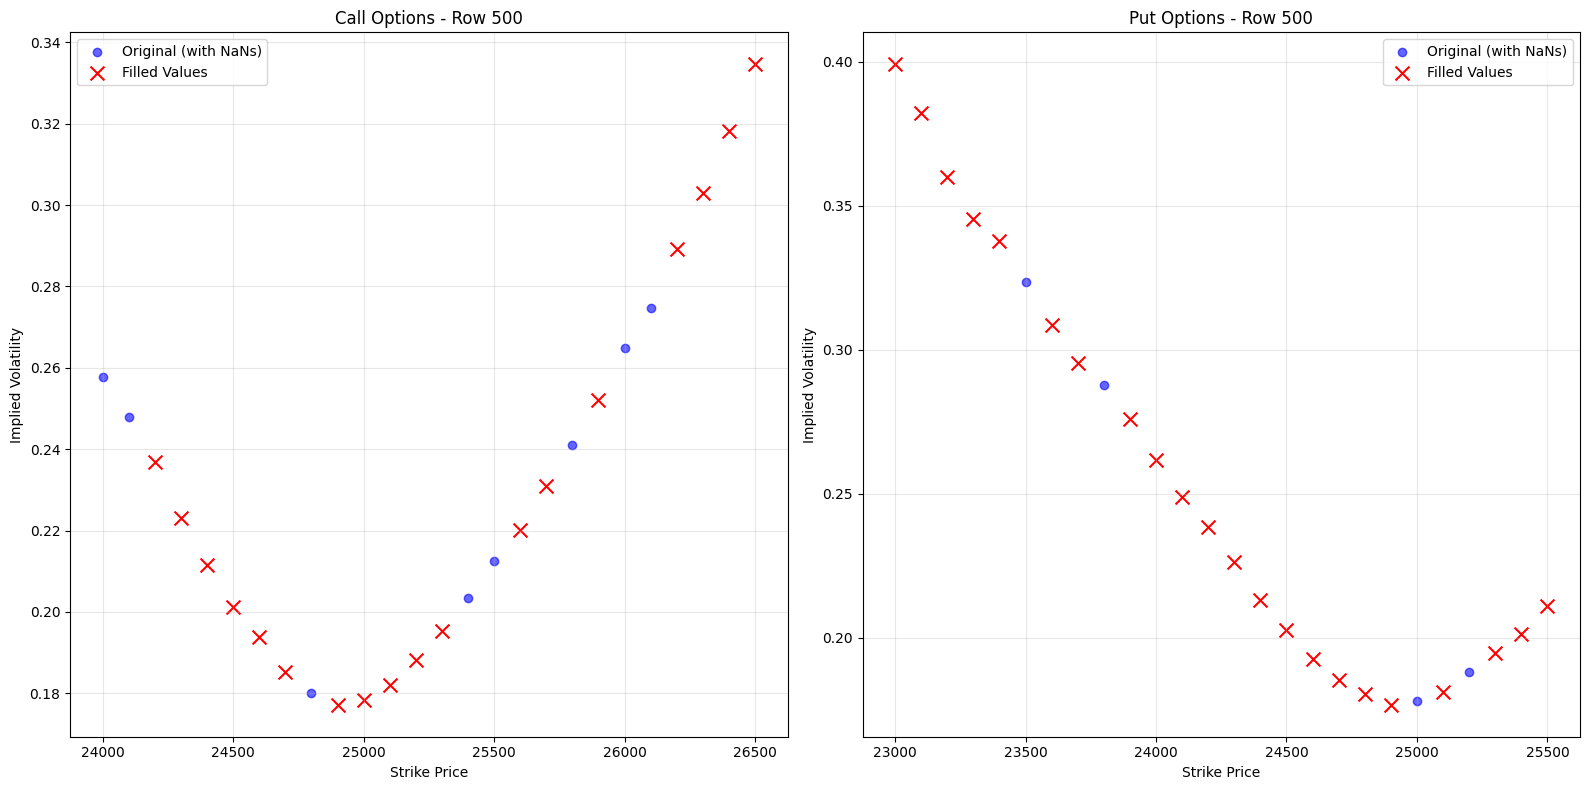

In [ ]:
# Load test data into another variable for comparison
original_test_data = pd.read_parquet("data/test_data.parquet")


def compare_predictions(row_idx, data_type=["call", "put"]):
    """
    Draw a graph comparing original test data with filled data for a specific row

    Parameters:
    row_idx (int): The index of the row to plot
    data_type (list): Types of options to plot - "call", "put", or both
    """
    plt.figure(figsize=(16, 8))

    if "call" in data_type:
        call_cols = [col for col in final_test_cols if col.startswith("call")]
        call_strikes = np.array([float(col.split("_")[-1]) for col in call_cols])

        plt.subplot(1, 2, 1)
        # Original data with NaNs
        plt.scatter(
            call_strikes,
            original_test_data.loc[row_idx, call_cols],
            color="blue",
            label="Original (with NaNs)",
            alpha=0.6,
        )

        # Plot NaN points differently
        nan_mask = original_test_data.loc[row_idx, call_cols].isna()
        plt.scatter(
            call_strikes[nan_mask],
            test_data.loc[row_idx, call_cols].values[nan_mask],
            color="red",
            marker="x",
            s=100,
            label="Filled Values",
        )

        plt.title("Call Options - Row {}".format(row_idx))
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.legend()
        plt.grid(True, alpha=0.3)

    if "put" in data_type:
        put_cols = [col for col in final_test_cols if col.startswith("put")]
        put_strikes = np.array([float(col.split("_")[-1]) for col in put_cols])

        plt.subplot(1, 2, 2)
        # Original data with NaNs
        plt.scatter(
            put_strikes,
            original_test_data.loc[row_idx, put_cols],
            color="blue",
            label="Original (with NaNs)",
            alpha=0.6,
        )

        # Plot NaN points differently
        nan_mask = original_test_data.loc[row_idx, put_cols].isna()
        plt.scatter(
            put_strikes[nan_mask],
            test_data.loc[row_idx, put_cols].values[nan_mask],
            color="red",
            marker="x",
            s=100,
            label="Filled Values",
        )

        plt.title("Put Options - Row {}".format(row_idx))
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Find a row with some NaN values to demonstrate

compare_predictions(500)